In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Dataset Preprocessing

Split data into train, validation and test:  
80% train, 10% validation, 10% test:

Years selected for test and validation (based of random number generation):
Valid and test years pairs are selected within one year of seperation
valid = 2022, 1999, 2008, 1990
test = 2023,  1998, 2009, 1991

In [2]:
# Data loading
datafolder = "./data/"
merge_df = pd.DataFrame()
for i, file in enumerate(os.listdir(datafolder)):
    file_path = os.path.join(datafolder, file)
    if i == 0:
        merge_df = pd.read_csv(file_path)
    else:
        df = pd.read_csv(file_path)
        merge_df = pd.merge(merge_df, df, on="month")

In [3]:
def normalised(df, min_max=True):
    excluded_columns = ["month"]
    merge_df_normalized_gaussian = df.copy()
    merge_df_normalized_minmax = df.copy()
    epsilon = 1e-10

    for column in merge_df_normalized_gaussian.columns:
        if column not in excluded_columns:
            merge_df_normalized_gaussian[column] = (merge_df_normalized_gaussian[column] - merge_df_normalized_gaussian[column].mean()) / merge_df_normalized_gaussian[column].std()

    for column in merge_df_normalized_minmax.columns:
        if column not in excluded_columns:
            merge_df_normalized_minmax[column] = (merge_df_normalized_minmax[column] - merge_df_normalized_minmax[column].min() + epsilon) / (merge_df_normalized_minmax[column].max() - merge_df_normalized_minmax[column].min() + epsilon)
    return merge_df_normalized_minmax if min_max else merge_df_normalized_gaussian

In [4]:
merge_df_normalized = normalised(merge_df, min_max=True)
merge_df_normalized['month'] = pd.to_datetime(merge_df_normalized['month'], format='%Y-%m').dt.to_period('M')
merge_df_normalized.set_index('month', inplace=True)

X = merge_df_normalized.values
y = merge_df_normalized['total_rainfall'].values

SEQ_LENGTH = 12

In [5]:
# Function to create sequences
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i + seq_length])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X, y, SEQ_LENGTH)

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

# Convert to PyTorch tensors
X_train, X_val, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_val, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [7]:
class RainfallDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(RainfallDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(RainfallDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(RainfallDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

## Create Transformer Model

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [10]:
class RainfallTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=2, dim_feedforward=128, dropout=0.1, seq_length=12):
        super(RainfallTransformer, self).__init__()
        self.input_norm = nn.LayerNorm(input_dim)
        self.input_linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_length)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_linear = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

    def forward(self, x):
        x = self.input_norm(x)
        x = self.input_linear(x) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        x = self.pos_encoder(x)
        x = self.dropout(x)
        x = self.transformer_encoder(x)
        x = self.output_linear(x[:, -1, :])
        return x.squeeze(-1)


In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)  # Pass only X_batch
            loss = criterion(output, y_batch)  # MSE loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)


         # Save best model
        if val_loss < min(val_losses[:-1], default=float('inf')):
            torch.save(model.state_dict(), 'transformer_best.pth')

        if epoch % 100 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return train_losses, val_losses

## Train

In [12]:
# Initialize model, optimizer, criterion
input_dim = X_train.shape[-1]
model = RainfallTransformer(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [362]:
# Train the model
num_epochs = 1000
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/1000, Train Loss: 0.185732, Val Loss: 0.072182
Epoch 101/1000, Train Loss: 0.010857, Val Loss: 0.012558
Epoch 201/1000, Train Loss: 0.004516, Val Loss: 0.010242
Epoch 301/1000, Train Loss: 0.002382, Val Loss: 0.012860
Epoch 401/1000, Train Loss: 0.002711, Val Loss: 0.010681
Epoch 501/1000, Train Loss: 0.001346, Val Loss: 0.013715
Epoch 601/1000, Train Loss: 0.001715, Val Loss: 0.012718
Epoch 701/1000, Train Loss: 0.003812, Val Loss: 0.011004
Epoch 801/1000, Train Loss: 0.001069, Val Loss: 0.015612
Epoch 901/1000, Train Loss: 0.001958, Val Loss: 0.012105


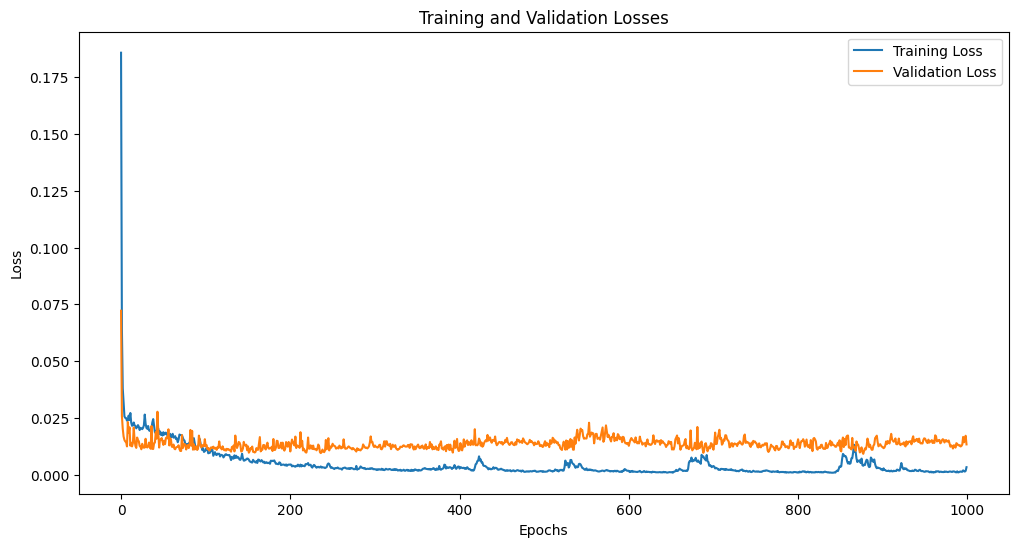

In [363]:
# Plot losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Display losses for final model

In [364]:
# Evaluate on validation set
model.eval()
validation_loss = 0
val_predictions, val_actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        loss = criterion(output, y_batch)
        validation_loss += loss.item() * X_batch.size(0)
        val_predictions.extend(output.cpu().numpy())
        val_actuals.extend(y_batch.cpu().numpy())
    validation_loss /= len(val_loader.dataset)

print(f"RMSE Validation Loss: {np.sqrt(validation_loss):.6f}")

RMSE Validation Loss: 0.115533


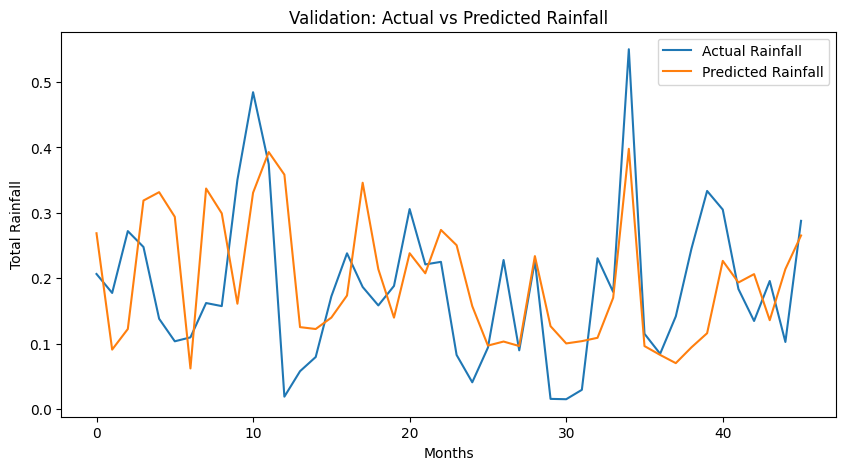

In [365]:
# Plot predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(val_actuals, label='Actual Rainfall')
plt.plot(val_predictions, label='Predicted Rainfall')
plt.xlabel('Months')
plt.ylabel('Total Rainfall')
plt.legend()
plt.title('Validation: Actual vs Predicted Rainfall')
plt.show()

In [366]:
# Evaluate on test set
model.eval()
test_loss = 0
test_predictions, test_actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        loss = criterion(output, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        test_predictions.extend(output.cpu().numpy())
        test_actuals.extend(y_batch.cpu().numpy())
    test_loss /= len(test_loader.dataset)

print(f"RMSE Test Loss: {np.sqrt(test_loss):.6f}")

RMSE Test Loss: 0.179922


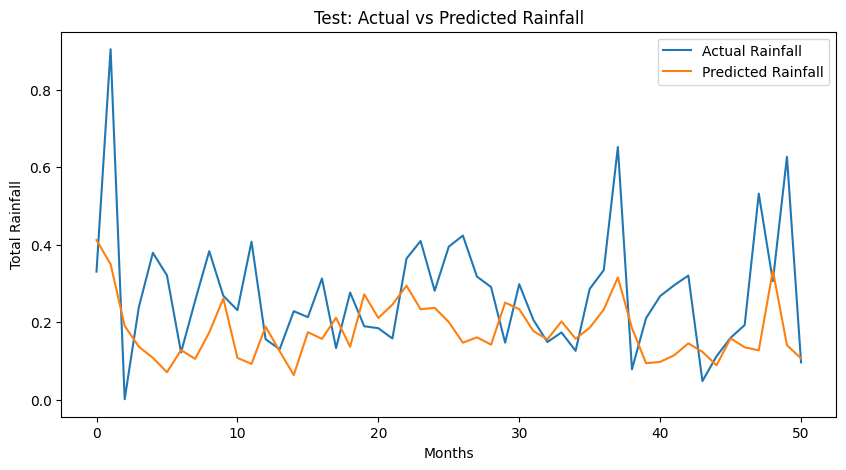

In [367]:
# Plot predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(test_actuals, label='Actual Rainfall')
plt.plot(test_predictions, label='Predicted Rainfall')
plt.xlabel('Months')
plt.ylabel('Total Rainfall')
plt.legend()
plt.title('Test: Actual vs Predicted Rainfall')
plt.show()

## Display losses for best model weights
### (Run below cells to use saved model weights)

In [14]:
model.load_state_dict(torch.load('transformer_encoder_model.pth', map_location=torch.device('cpu')))

RuntimeError: Error(s) in loading state_dict for RainfallTransformer:
	Missing key(s) in state_dict: "input_norm.weight", "input_norm.bias", "pos_encoder.pe". 
	Unexpected key(s) in state_dict: "pos_encoder". 
	size mismatch for input_linear.weight: copying a param with shape torch.Size([64, 9]) from checkpoint, the shape in current model is torch.Size([128, 9]).
	size mismatch for input_linear.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.0.self_attn.in_proj_weight: copying a param with shape torch.Size([192, 64]) from checkpoint, the shape in current model is torch.Size([384, 128]).
	size mismatch for transformer_encoder.layers.0.self_attn.in_proj_bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for transformer_encoder.layers.0.self_attn.out_proj.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for transformer_encoder.layers.0.self_attn.out_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.0.linear1.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for transformer_encoder.layers.0.linear2.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for transformer_encoder.layers.0.linear2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.0.norm1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.0.norm1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.0.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.0.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.1.self_attn.in_proj_weight: copying a param with shape torch.Size([192, 64]) from checkpoint, the shape in current model is torch.Size([384, 128]).
	size mismatch for transformer_encoder.layers.1.self_attn.in_proj_bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for transformer_encoder.layers.1.self_attn.out_proj.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for transformer_encoder.layers.1.self_attn.out_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.1.linear1.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for transformer_encoder.layers.1.linear2.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for transformer_encoder.layers.1.linear2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.1.norm1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.1.norm1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.1.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.1.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for output_linear.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).

In [369]:
# Evaluate on validation set
model.eval()
validation_loss = 0
val_predictions, val_actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        loss = criterion(output, y_batch)
        validation_loss += loss.item() * X_batch.size(0)
        val_predictions.extend(output.cpu().numpy())
        val_actuals.extend(y_batch.cpu().numpy())
    validation_loss /= len(val_loader.dataset)

print(f"RMSE Validation Loss: {np.sqrt(validation_loss):.6f}")

RMSE Validation Loss: 0.095846


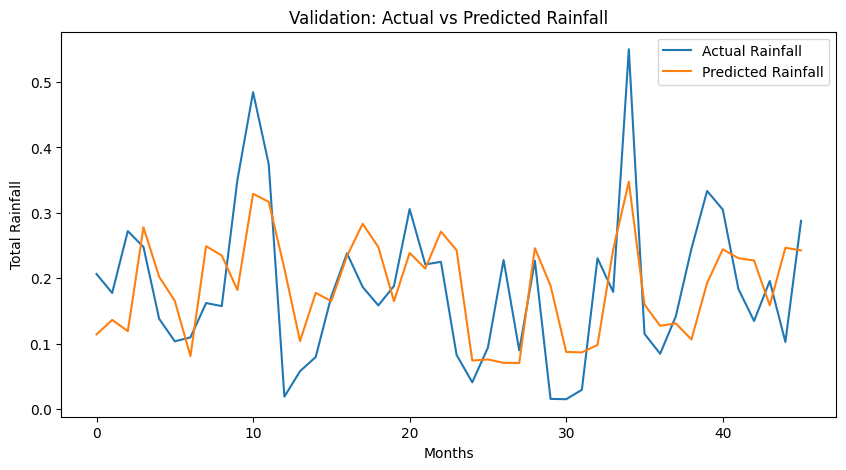

In [370]:
# Plot predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(val_actuals, label='Actual Rainfall')
plt.plot(val_predictions, label='Predicted Rainfall')
plt.xlabel('Months')
plt.ylabel('Total Rainfall')
plt.legend()
plt.title('Validation: Actual vs Predicted Rainfall')
plt.show()

In [371]:
# Evaluate on test set
model.eval()
test_loss = 0
test_predictions, test_actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        loss = criterion(output, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        test_predictions.extend(output.cpu().numpy())
        test_actuals.extend(y_batch.cpu().numpy())
    test_loss /= len(test_loader.dataset)

print(f"RMSE Test Loss: {np.sqrt(test_loss):.6f}")

RMSE Test Loss: 0.169512


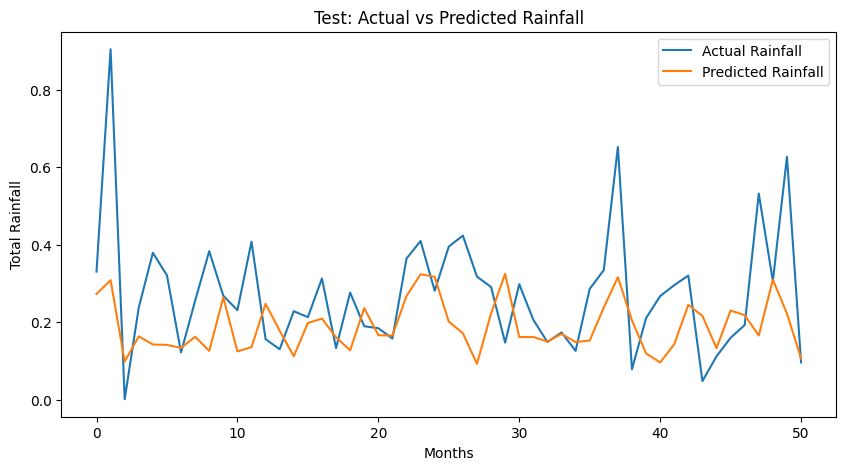

In [372]:
# Plot predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(test_actuals, label='Actual Rainfall')
plt.plot(test_predictions, label='Predicted Rainfall')
plt.xlabel('Months')
plt.ylabel('Total Rainfall')
plt.legend()
plt.title('Test: Actual vs Predicted Rainfall')
plt.show()